<a href="https://colab.research.google.com/github/SPhilogene/JREHD-Prostate-SDOH/blob/main/Prostate_Cancer_%26_SDOH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Packages

In [ ]:
import warnings

# basic packages
import pandas as pd  # To read data
import numpy as np # mapth
from numpy import mean, std
import matplotlib as mpl
import matplotlib.pyplot as plt  # To visualize
from matplotlib import colors
import seaborn as sns # correlation & regression scatterplots
import statsmodels.api as sm

# regression modeling
import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.feature_selection import VarianceThreshold,  SequentialFeatureSelector


In [ ]:
!pip install contextily
import contextily

In [ ]:
!pip install libpysal
!pip install geopandas
!pip install pysal
# !pip install contextily # sometimes needed
# !pip install mgwr

# spatial analysis and modeling
import geopandas as gpd
import libpysal as ps
import pysal
from pysal.explore import esda
from pysal.lib import weights
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


ModuleNotFoundError: No module named 'contextily'

In [ ]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

In [ ]:
#### **********************************************************************
#### ***************** FORWARD STEPWISE SELECTION METHOD ******************
#### **********************************************************************

# **** Created on Mon Jul 16 14:45:40 2018
# **** @author: kaygo
# **** https://github.com/KaygoYM/Big-Data-Prediction/blob/master/forward_selected.py
#

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

#### Box Cox transformations for normal distributions

In [ ]:
# # Box Cox transformations on each variable to improve normality of the distribution

# def transformations(x):

#   n2 = x**-2 if x != 0 else 0
#   n1_5 = x**-1.5 if x != 0 else 0
#   n1 = x**-1 if x != 0 else 0
#   n0_5 = x**-0.5 if x != 0 else 0
#   log = np.log(x) if x != 0 else 0
#   p0_5 = x**0.5 if x != 0 else 0
#   x = x
#   p1_5 = x**1.5 if x != 0 else 0
#   p2 = x**2 if x != 0 else 0

#   return pd.Series([n2,n1_5, n1, n0_5, log, p0_5, x, p1_5, p2])


# def logTransform(x):
#   log = np.log(x) if x != 0 else 0
#   return pd.Series([log])


# def sqRTransform(x):
#   p0_5 = x**0.5 if x != 0 else 0
#   return pd.Series([p0_5])

# Data Preprocessing

## Read Data

In [ ]:
newYork = pd.read_csv('NYC Prostate.csv') # read in NYSCR data
newYork.head()

Long        GEOID   FIPS    County  Primary Census Tract  \
0  1400000US36061009400  36061009400  36061  New York                 94.00   
1  1400000US36047107000  36047107000  36047     Kings               1070.00   
2  1400000US36061009900  36061009900  36061  New York                 99.00   
3  1400000US36085032300  36085032300  36085  Richmond                323.00   
4  1400000US36005022703  36005022703  36005     Bronx                227.03   

   Prostate__Observed  Prostate__Expected  Prostate_SIR  Prostate_Crude Signif  
0                   5                 0.3     16.666667      454.545455      Y  
1                   6                 1.2      5.000000       11.605416      Y  
2                  13                 3.0      4.333333        4.671218      Y  
3                  12                 3.4      3.529412        2.826855      Y  
4                  10                 3.0      3.333333       12.239902      Y

In [ ]:
# Read in shapefile and limit to study area for spatial analysis

State = gpd.read_file("tl_2015_36_tract.shp") # tigerline includes GEOID and all NYS
State['point'] = State.centroid # centroids to get x,y coordinates

State['GEOID'] = State['GEOID'].astype(int)
p = ['005','047','061','081','085']

NYC = State[State['COUNTYFP'].isin(p)].reset_index(drop=True)

<ipython-input-11-ad09ee6d2d6f>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  State['point'] = State.centroid # centroids to get x,y coordinates


## Demographic Data

In [ ]:
demographs = pd.read_csv('Demog 2015 Male.csv')
demographs = demographs.drop(['County','NAME'], axis=1)
# demographs = demographs.rename(columns={'Tract':'GEOID'})
demographs = demographs.replace([np.inf, -np.inf, np.nan], 0)
demographs = demographs.drop(demographs.filter(regex='Female|female|Women|women|Woman|woman').columns, axis=1)
outcomeDemo = pd.merge(left=newYork, right=demographs, how='left')
outcomeDemo = outcomeDemo.replace([np.inf, -np.inf, np.nan], 0)
outcomeDemo

Long        GEOID   FIPS    County  \
0     1400000US36061009400  36061009400  36061  New York   
1     1400000US36047107000  36047107000  36047     Kings   
2     1400000US36061009900  36061009900  36061  New York   
3     1400000US36085032300  36085032300  36085  Richmond   
4     1400000US36005022703  36005022703  36005     Bronx   
...                    ...          ...    ...       ...   
2084  1400000US36047044700  36047044700  36047     Kings   
2085  1400000US36081029300  36081029300  36081    Queens   
2086  1400000US36081005500  36081005500  36081    Queens   
2087  1400000US36047040500  36047040500  36047     Kings   
2088  1400000US36061011300  36061011300  36061  New York   

      Primary Census Tract  Prostate__Observed  Prostate__Expected  \
0                    94.00                   5                 0.3   
1                  1070.00                   6                 1.2   
2                    99.00                  13                 3.0   
3                   323.00                  12                 3.4   
4                   227.03                  10                 3.0   
...                    ...                 ...                 ...   
2084                447.00                   0                 3.9   
2085                293.00                   0                 3.8   
2086                 55.00                   0                 3.3   
2087                405.00                   0                 3.1   
2088                113.00                   0                 0.2   

      Prostate_SIR  Prostate_Crude Signif  ...  \
0        16.666667      454.545455      Y  ...   
1         5.000000       11.605416      Y  ...   
2         4.333333        4.671218      Y  ...   
3         3.529412        2.826855      Y  ...   
4         3.333333       12.239902      Y  ...   
...            ...             ...    ...  ...   
2084      0.000000        0.000000      Y  ...   
2085      0.000000        0.000000      Y  ...   
2086      0.000000        0.000000      Y  ...   
2087      0.000000        0.000000      Y  ...   
2088      0.000000        0.000000      Y  ...   

      S1603_Speak_a_language_other_than_English_at_home_Pct_speak_Spanish_at_home_Estimate_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born  \
0                                                  40.8                                                                                   
1                                                   0.0                                                                                   
2                                                  29.4                                                                                   
3                                                   0.0                                                                                   
4                                                  45.0                                                                                   
...                                                 ...                                                                                   
2084                                               57.8                                                                                   
2085                                               41.4                                                                                   
2086                                                0.0                                                                                   
2087                                               38.9                                                                                   
2088                                                8.9                                                                                   

      S1603_Speak_a_language_other_than_English_at_home_Pct_speak_Spanish_at_home_Estimate_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born_Naturalized_US_citizen  \
0                           

## Health Outcomes *(PLACES 2020 Release)*

In [ ]:
places = pd.read_csv('PLACES 2015.csv')
# State['GEOID'] = State['GEOID'].astype(int)
# places = pd.merge(left=newYork, right=places, how='left')
outcomeDemoPlace = pd.merge(left=outcomeDemo, right=places, how='left')
outcomeDemoPlace

Long        GEOID   FIPS    County  \
0     1400000US36061009400  36061009400  36061  New York   
1     1400000US36047107000  36047107000  36047     Kings   
2     1400000US36061009900  36061009900  36061  New York   
3     1400000US36085032300  36085032300  36085  Richmond   
4     1400000US36005022703  36005022703  36005     Bronx   
...                    ...          ...    ...       ...   
2084  1400000US36047044700  36047044700  36047     Kings   
2085  1400000US36081029300  36081029300  36081    Queens   
2086  1400000US36081005500  36081005500  36081    Queens   
2087  1400000US36047040500  36047040500  36047     Kings   
2088  1400000US36061011300  36061011300  36061  New York   

      Primary Census Tract  Prostate__Observed  Prostate__Expected  \
0                    94.00                   5                 0.3   
1                  1070.00                   6                 1.2   
2                    99.00                  13                 3.0   
3                   323.00                  12                 3.4   
4                   227.03                  10                 3.0   
...                    ...                 ...                 ...   
2084                447.00                   0                 3.9   
2085                293.00                   0                 3.8   
2086                 55.00                   0                 3.3   
2087                405.00                   0                 3.1   
2088                113.00                   0                 0.2   

      Prostate_SIR  Prostate_Crude Signif  ...  KIDNEY_CrudePrev  \
0        16.666667      454.545455      Y  ...               1.6   
1         5.000000       11.605416      Y  ...               3.1   
2         4.333333        4.671218      Y  ...               1.4   
3         3.529412        2.826855      Y  ...               2.9   
4         3.333333       12.239902      Y  ...               3.1   
...            ...             ...    ...  ...               ...   
2084      0.000000        0.000000      Y  ...               2.4   
2085      0.000000        0.000000      Y  ...               2.2   
2086      0.000000        0.000000      Y  ...               2.2   
2087      0.000000        0.000000      Y  ...               2.9   
2088      0.000000        0.000000      Y  ...               1.7   

      LPA_CrudePrev  MAMMOUSE_CrudePrev  MHLTH_CrudePrev  OBESITY_CrudePrev  \
0               9.9                83.8              8.3               14.0   
1              25.2                84.6             12.0               30.3   
2              12.5                84.9             10.4               18.1   
3              29.3                81.4             14.7               36.8   
4              31.9                82.6             14.6               29.8   
...             ...                 ...              ...                ...   
2084           28.3                82.3             15.9               26.8   
2085           32.5                75.8             10.8               19.5   
2086           28.0                77.5             11.8               24.3   
2087           26.8                84.3             13.2               28.9   
2088           19.9                81.9             14.0               18.3   

      PHLTH_CrudePrev  SLEEP_CrudePrev  STROKE_CrudePrev  TEETHLOST_CrudePrev  \
0                 5.4             33.0               1.4                  4.0   
1                10.6             45.0               3.5                 15.0   
2                 6.6             37.1               1.2                  6.2   
3                12.9             48.4               3.1                 17.9   
4                13.8             41.6               2.9                 18.2   
...               ...              ...               ...                  ...   
2084             11.5             41.1               2.1                 18.1   
2085             10.9             41.6        

## '#' Remediations Sites

In [ ]:
# analyze all together and by site type

remediation = gpd.read_file("Remediation_Sites.shp")
activeLandfill = gpd.read_file("Active_Landfills.shp").to_crs(remediation.crs)
inactiveLandfill = gpd.read_file("Inactive_Solid_Waste_Landfills.shp").to_crs(remediation.crs)
site2 = remediation[remediation['SITECLASS'].str.contains('2')]
site3 = remediation[remediation['SITECLASS'].str.contains('3')]
site4 = remediation[remediation['SITECLASS'].str.contains('4')]
siteTox = remediation[remediation['SITECLASS'].str.contains('2|3|4')]
landfillName = remediation[remediation['SITENAME'].str.contains("Landfill")]
# contextily.add_basemap(ax, crs=map11t21.crs, source=contextily.providers.CartoDB.Voyager)

print('remediation', len(remediation))
print('activeLandfill', len(activeLandfill))
print('inactiveLandfill', len(inactiveLandfill))
print('site 2', len(remediation[remediation['SITECLASS'].str.contains('2')]))
print('site 3', len(remediation[remediation['SITECLASS'].str.contains('3')]))
print('site 4', len(remediation[remediation['SITECLASS'].str.contains('4')]))
print('site 2,3,4', len(remediation[remediation['SITECLASS'].str.contains('2|3|4')]))
print('landfills', len(remediation[remediation['SITENAME'].str.contains("Landfill")]))#.plot()

remediation 5617
activeLandfill 50
inactiveLandfill 1957
site 2 428
site 3 42
site 4 466
site 2,3,4 936
landfills 283


In [ ]:
spatialJoinRem = gpd.sjoin(remediation, NYC).reset_index(drop=True)
spatialJoinAct = gpd.sjoin(activeLandfill, NYC).reset_index(drop=True)
spatialJoinInact = gpd.sjoin(inactiveLandfill, NYC).reset_index(drop=True)
spatialJoinSite2 = gpd.sjoin(site2, NYC).reset_index(drop=True)
spatialJoinSite3 = gpd.sjoin(site3, NYC).reset_index(drop=True)
spatialJoinSite4 = gpd.sjoin(site4, NYC).reset_index(drop=True)
spatialJoinTox = gpd.sjoin(siteTox, NYC).reset_index(drop=True)
spatialJoinLandfill = gpd.sjoin(landfillName, NYC).reset_index(drop=True)

remediationTractCount = spatialJoinRem[['OBJECTID', 'GEOID']].groupby(['GEOID']).count().reset_index().rename(columns= {'OBJECTID':'remediationTractCount'})
activeTractCount = spatialJoinAct[['FACILITY_N', 'GEOID']].groupby(['GEOID']).count().reset_index().rename(columns= {'FACILITY_N':'activeTractCount'})
inactiveTractCount = spatialJoinInact[['FACILITY_N', 'GEOID']].groupby(['GEOID']).count().reset_index().rename(columns= {'FACILITY_N':'inactiveTractCount'})
site2TractCount = spatialJoinSite2[['OBJECTID', 'GEOID']].groupby(['GEOID']).count().reset_index().rename(columns= {'OBJECTID':'site2TractCount'})
site3TractCount = spatialJoinSite3[['OBJECTID', 'GEOID']].groupby(['GEOID']).count().reset_index().rename(columns= {'OBJECTID':'site3TractCount'})
site4TractCount = spatialJoinSite4[['OBJECTID', 'GEOID']].groupby(['GEOID']).count().reset_index().rename(columns= {'OBJECTID':'site4TractCount'})
toxTractCount = spatialJoinTox[['OBJECTID', 'GEOID']].groupby(['GEOID']).count().reset_index().rename(columns= {'OBJECTID':'toxTractCount'})
landfillTractCount = spatialJoinLandfill[['OBJECTID', 'GEOID']].groupby(['GEOID']).count().reset_index().rename(columns= {'OBJECTID':'landfillTractCount'})

<ipython-input-16-3167ee4abf93>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  spatialJoinRem = gpd.sjoin(remediation, NYC).reset_index(drop=True)
<ipython-input-16-3167ee4abf93>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  spatialJoinAct = gpd.sjoin(activeLandfill, NYC).reset_index(drop=True)
<ipython-input-16-3167ee4abf93>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  spatialJoinInact = gpd.sjoin(inactiveLandfill, NYC).reset_index(drop=True)
<ip

In [ ]:
outcomeDemoPlaceRem = outcomeDemoPlace.merge(remediationTractCount,on='GEOID',how='left').merge(activeTractCount,on='GEOID',how='left').merge(inactiveTractCount,on='GEOID',how='left').merge(site2TractCount,on='GEOID',how='left').merge(site3TractCount,on='GEOID',how='left').merge(site4TractCount,on='GEOID',how='left').merge(toxTractCount,on='GEOID',how='left').merge(landfillTractCount,on='GEOID',how='left')
outcomeDemoPlaceRem = outcomeDemoPlaceRem.replace([np.inf, -np.inf, np.nan], 0)

outcomeDemoPlaceRem.head()

Long        GEOID   FIPS    County  Primary Census Tract  \
0  1400000US36061009400  36061009400  36061  New York                 94.00   
1  1400000US36047107000  36047107000  36047     Kings               1070.00   
2  1400000US36061009900  36061009900  36061  New York                 99.00   
3  1400000US36085032300  36085032300  36085  Richmond                323.00   
4  1400000US36005022703  36005022703  36005     Bronx                227.03   

   Prostate__Observed  Prostate__Expected  Prostate_SIR  Prostate_Crude  \
0                   5                 0.3     16.666667      454.545455   
1                   6                 1.2      5.000000       11.605416   
2                  13                 3.0      4.333333        4.671218   
3                  12                 3.4      3.529412        2.826855   
4                  10                 3.0      3.333333       12.239902   

  Signif  ...  TEETHLOST_CrudePrev                       Geolocation  \
0      Y  ...                  4.0    POINT (-73.9777301 40.7552386)   
1      Y  ...                 15.0  POINT (-73.86926351 40.64888166)   
2      Y  ...                  6.2  POINT (-74.00487913 40.75198608)   
3      Y  ...                 17.9  POINT (-74.17857341 40.63400714)   
4      Y  ...                 18.2  POINT (-73.91046778 40.84397073)   

   remediationTractCount  activeTractCount  inactiveTractCount  \
0                    1.0               0.0                 0.0   
1                    2.0               0.0                 3.0   
2                   20.0               0.0                 0.0   
3                    7.0               0.0                 2.0   
4                    0.0               0.0                 0.0   

   site2TractCount  site3TractCount  site4TractCount  toxTractCount  \
0              0.0              0.0              0.0            0.0   
1              0.0              0.0              2.0            2.0   
2              0.0              0.0              0.0            0.0   
3              0.0              0.0              0.0            0.0   
4              0.0              0.0              0.0            0.0   

   landfillTractCount  
0                 0.0  
1                 2.0  
2                 0.0  
3                 1.0  
4                 0.0  

[5 rows x 2578 columns]

## Emissions/Air Quality

In [ ]:
Emissions = pd.read_csv('Log Emissions.csv')
Emissions['Total_Conc'] = abs(Emissions['Total_Conc'])
Emissions = Emissions.replace([np.inf, -np.inf, np.nan], 0)

cols = ['Total_Conc',
       'Total_Exposure_Conc', 'Total_Cancer',
       'Total_Respiratory_HI']

Emissions[cols] = Emissions[cols].apply(pd.to_numeric, errors='coerce')

Emissions.head()

County   FIPS        Tract  Population         Pollutant_Name  Total_Conc  \
0  Albany  36001  36001000100        2139  1_1_1_TRICHLOROETHANE    2.982567   
1  Albany  36001  36001000200        6046  1_1_1_TRICHLOROETHANE    2.962826   
2  Albany  36001  36001000300        5888  1_1_1_TRICHLOROETHANE    2.921671   
3  Albany  36001  36001000401        2227  1_1_1_TRICHLOROETHANE    2.821532   
4  Albany  36001  36001000403        4415  1_1_1_TRICHLOROETHANE    2.909374   

   Total_Exposure_Conc  Total_Cancer  Total_Respiratory_HI  
0             0.033081           0.0                   0.0  
1             0.074947           0.0                   0.0  
2            -0.030674           0.0                   0.0  
3             0.076353           0.0                   0.0  
4             0.013090           0.0                   0.0

In [ ]:
# rename pollutants that start with number, add leading character to prevent syntax errors

Emissions['Pollutant_Name'] = np.where([i.startswith(("1","2","3","4")) for i in Emissions['Pollutant_Name']],'c'+Emissions['Pollutant_Name'],Emissions['Pollutant_Name'])

pollutants = Emissions['Pollutant_Name'].unique()
# pollutants

In [ ]:
# pivot
pollutants = Emissions['Pollutant_Name'].unique()
df4 = Emissions[Emissions['Pollutant_Name'] == pollutants[0]][['County','FIPS','Tract','Population']].reset_index(drop=True)

for d in pollutants:
  df4[d+'_Total_Conc'] = Emissions[Emissions['Pollutant_Name'] == d]['Total_Conc'].reset_index(drop=True)
  # df4[d+'_Total_Expos'] = Emissions[Emissions['Pollutant_Name'] == d]['Total_Exposure_Conc'].reset_index(drop=True)

df4

<ipython-input-20-91df0a654066>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df4[d+'_Total_Conc'] = Emissions[Emissions['Pollutant_Name'] == d]['Total_Conc'].reset_index(drop=True)
<ipython-input-20-91df0a654066>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df4[d+'_Total_Conc'] = Emissions[Emissions['Pollutant_Name'] == d]['Total_Conc'].reset_index(drop=True)
<ipython-input-20-91df0a654066>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

County   FIPS        Tract  Population  \
0     Albany  36001  36001000100        2139   
1     Albany  36001  36001000200        6046   
2     Albany  36001  36001000300        5888   
3     Albany  36001  36001000401        2227   
4     Albany  36001  36001000403        4415   
...      ...    ...          ...         ...   
4865   Yates  36123  36123150100        5942   
4866   Yates  36123  36123150200        5561   
4867   Yates  36123  36123150300        5348   
4868   Yates  36123  36123150400        3973   
4869   Yates  36123  36123150500        4524   

      c1_1_1_TRICHLOROETHANE_Total_Conc  \
0                              2.982567   
1                              2.962826   
2                              2.921671   
3                              2.821532   
4                              2.909374   
...                                 ...   
4865                           3.692296   
4866                           3.712212   
4867                           3.781547   
4868                           3.765112   
4869                           3.744772   

      c1_1_2_2_TETRACHLOROETHANE_Total_Conc  \
0                                  8.376832   
1                                  8.463254   
2                                  8.838491   
3                                  7.000082   
4                                  9.192131   
...                                     ...   
4865                               9.430257   
4866                               9.625653   
4867                               9.601268   
4868                               9.359954   
4869                               9.247078   

      c1_1_2_TRICHLOROETHANE_Total_Conc  c1_1_DIMETHYLHYDRAZINE_Total_Conc  \
0                             10.009238                                0.0   
1                             10.091515                                0.0   
2                             10.043055                                0.0   
3                             10.637471                                0.0   
4                             10.111656                                0.0   
...                                 ...                                ...   
4865                          16.361676                                0.0   
4866                          16.629402                                0.0   
4867                          17.715093                                0.0   
4868                          17.057441                                0.0   
4869                          16.584848                                0.0   

      c1_2_3_4_5_6_HEXACHLOROCYCLYHEXANE_Total_Conc  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
4865                                            0.0   
4866                                            0.0   
4867                                            0.0   
4868                                            0.0   
4869                                            0.0   

      c1_2_4_TRICHLOROBENZENE_Total_Conc  ...  TOLUENE_Total_Conc  \
0                              13.929330  ...            0.165896   
1                              13.996442  ...            0.216623   
2                              14.233614  ...            0.226652   
3                              14.570103  ...            0.441269   
4                              14.412762  ...            0.220140   
...                                  ...  ...                 ...   
4865                           16.638198  ...            0.969245   
4866                           16.686903  ...            1.158054   
4867                           17.374095  ...            1.299785   
4868                           17.258158  ...            1.

## Combine All Data

In [ ]:
allData = pd.merge(left=outcomeDemoPlaceRem, right=df4.iloc[:, 2:], left_on='GEOID', right_on='Tract', how='left')
allData = allData.drop(['CountyName','Geolocation'], axis=1)
allData = allData.replace([np.inf, -np.inf, np.nan], 0)

# All Data LISA

In [ ]:
NYC = gpd.read_file("geo_export_bdbf7bca-75d9-403c-85cb-132a46cffdf9.shp")
NYC['point'] = NYC.centroid
NYC['boro_ct201'] = NYC['boro_ct201'].astype(int)

mapIt = pd.merge(left=NYC, right=allData)#[allData['Prostate_SIR'] < 4])
geoAllData = gpd.GeoDataFrame(mapIt, geometry="geometry").to_crs(crs="EPSG:2263")
geoIncluData = geoAllData[~(geoAllData['Prostate_SIR'] < 0.2) & ~(geoAllData['Prostate_SIR'] >= 4)] #3sd - remove extreme outliers
geoModerateData = geoAllData[~(geoAllData['Prostate_SIR'] < 0.344) & ~(geoAllData['Prostate_SIR'] >= 2.6)] # 2sd - remove moderate outliers
geoOutlierData = geoAllData[(geoAllData['Prostate_SIR'] < 0.344) | (geoAllData['Prostate_SIR'] >= 2.6)]
xOutlier = geoAllData[(geoAllData['Prostate_SIR'] < 0.2) | (geoAllData['Prostate_SIR'] >= 4)] # only 3sd outliers
geoAllData = geoAllData.drop(['boro_ct201'], axis=1)

boro = gpd.read_file("geo_export_07056f3a-e540-49fa-b98d-78295b1e1c85.shp").to_crs(crs="EPSG:2263")
boro['point'] = boro.centroid

<ipython-input-22-c7017a4133fb>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  NYC['point'] = NYC.centroid


In [ ]:
# print(len(data))
print(len(allData))
print(len(geoAllData)) # all
print(len(geoIncluData)) # within 3sd
print(len(geoModerateData)) # within 2sd
print(len(geoOutlierData)) # outside 2sd outliers
print(len(xOutlier)) # outside 3sd outliers

2089
2089
2067
1993
96
22


Text(0.5, 1.0, 'New York City')

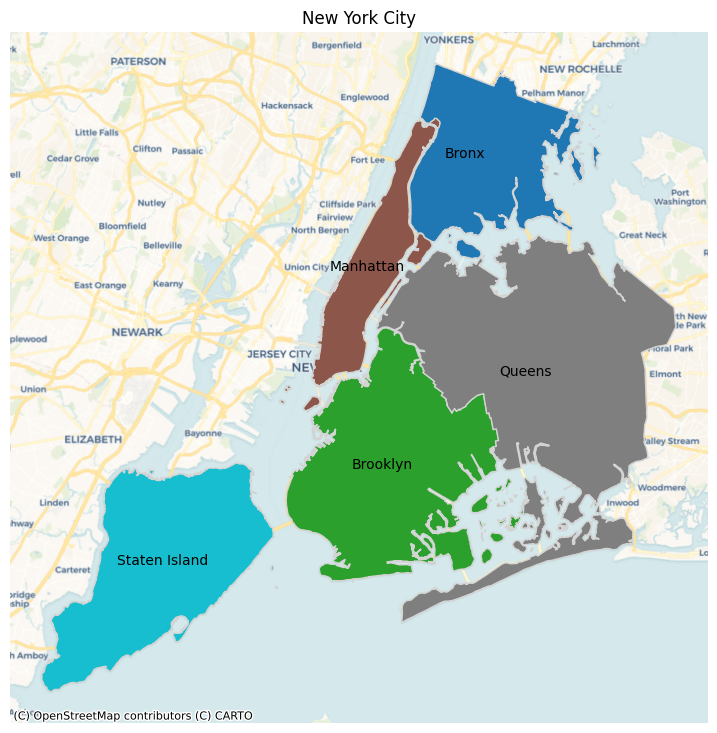

In [ ]:
fig, ax = plt.subplots(1, figsize=(9, 9))#, dpi=300)

boro.plot('boro_name', ax=ax, cmap='tab10', edgecolor='lightgray')

for x, y, label in zip(boro.point.x, boro.point.y, boro.boro_name):
    ax.annotate(label, xy=(x, y), xytext=(-30, 0), textcoords="offset points")
contextily.add_basemap(ax=ax, crs=boro.crs, source=contextily.providers.CartoDB.Voyager)

ax.set_axis_off()
plt.title("New York City")
# plt.savefig('Fig1.png', dpi=300)

Text(0.5, 1.0, 'Ratio of Observed/Expected Cases (within 3σ)')

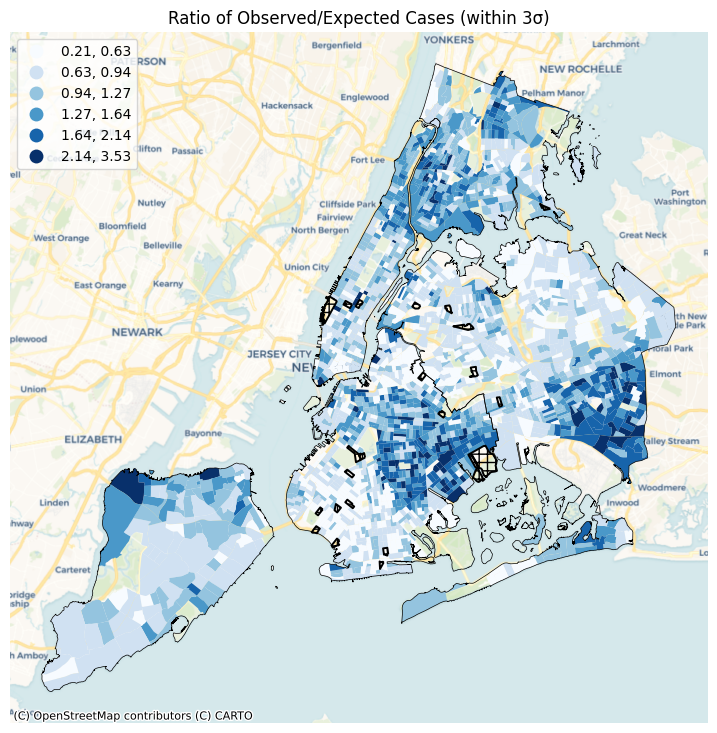

In [ ]:
fig, ax = plt.subplots(1, figsize=(9, 9))#, dpi=300)
geoIncluData.plot('Prostate_SIR', cmap='Blues', scheme='naturalbreaks',  k=6, ax=ax, legend=True, legend_kwds={'loc': 'upper left'})
boro.plot('boro_name', ax=ax, facecolor="none", edgecolor='black', linewidth=.5)
xOutlier.plot('Prostate_SIR', ax=ax, facecolor='none',  hatch='++', edgecolor='black', linewidth=1.4) # excluded tracts
# geoIncluData[geoIncluData['Signif'] == 'Y'].plot('Signif', ax=ax, facecolor='None', alpha=.5, edgecolor='cyan')
contextily.add_basemap(ax=ax, crs=geoAllData.crs, source=contextily.providers.CartoDB.Voyager)

ax.set_axis_off()
plt.title("Ratio of Observed/Expected Cases (within 3\u03C3)")
# plt.savefig('Fig2.png', dpi=300)

<ipython-input-26-21c8c8cb09d4>:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = ps.weights.Queen.from_dataframe(geoIncluData) # calculate spatial weight based data and conceptualized spatial relationships is Queens case (aka contiguity edges corners)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 4 islands with ids: 949, 1305, 1560, 2059.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 949, ' is an island (no neighbors)')
('WARNING: ', 1305, ' is an island (no neighbors)')
('WARNING: ', 1560, ' is an island (no neighbors)')
('WARNING: ', 2059, ' is an island (no neighbors)')
Observed Value: 0.40463344677839996 | Expected Value: -0.000484027105517909 | Z-Score 30.40018409613299 | Significance: 0.0001

The Global Moran's I statistics indicates that the data exhibits a statistically significant clustering pattern


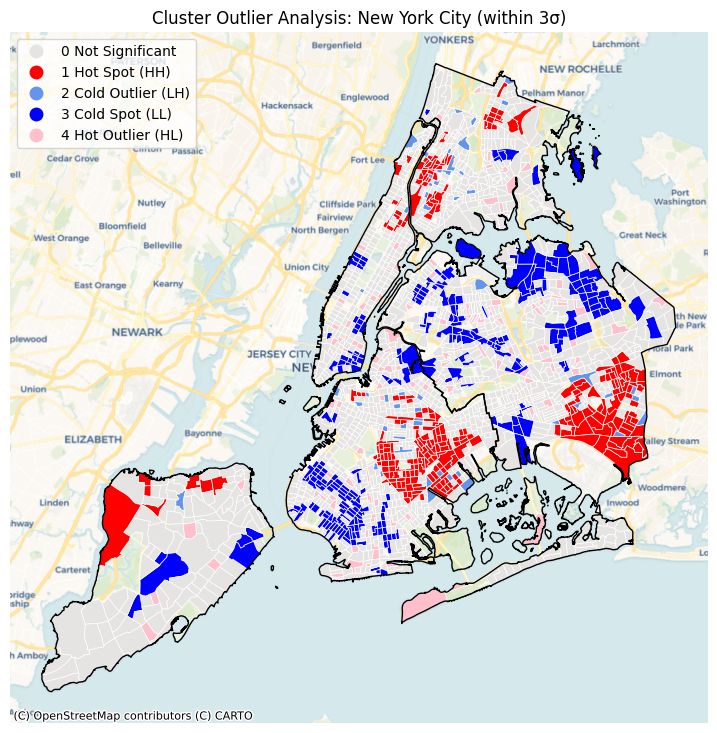

In [ ]:
w = ps.weights.Queen.from_dataframe(geoIncluData) # calculate spatial weight based data and conceptualized spatial relationships is Queens case (aka contiguity edges corners)
w.transform = 'r' # row standardize
y = geoIncluData['Prostate_SIR'].values.reshape((-1,1)).astype('int64')

mi = esda.moran.Moran(y, w, permutations= 9999) # p < 0.001 at 999 permutations
print('Observed Value:', mi.I, '| Expected Value:', mi.EI, '| Z-Score', mi.z_norm, '| Significance:', mi.p_sim)
print('')
print("The Global Moran's I statistics indicates that the data exhibits a statistically significant clustering pattern")

lisa = esda.moran.Moran_Local(y, w, permutations= 9999)

sig = 1 * (lisa.p_sim < 0.05) # creates binary (based on T/F)
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
ice = 2 * (sig * lisa.q==2)
fire = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + ice + fire

spot_labels = [ '0 Not Significant', '1 Hot Spot (HH)', '2 Cold Outlier (LH)', '3 Cold Spot (LL)', '4 Hot Outlier (HL)']
labels = [spot_labels[i] for i in spots]

hmap = colors.ListedColormap([ '#E5E4E2', 'red', 'cornflowerblue', 'blue', 'pink']) # cornflower = #6395ed
fig, ax = plt.subplots(1, figsize=(9, 9))#, dpi=300)
cc = geoIncluData.assign(COanalysis=labels).plot(column='COanalysis', categorical=True, \
        k=2, cmap=hmap, linewidth=0.5, ax=ax, \
        edgecolor='white', legend=True, legend_kwds={'loc': 'upper left'})
plt.title("Cluster Outlier Analysis: New York City (within 3\u03C3)")

boro.plot('boro_name', ax=ax, facecolor="none", edgecolor='black')
contextily.add_basemap(ax, crs=geoIncluData.crs, source=contextily.providers.CartoDB.Voyager)

ax.set_axis_off()
plt.show()
# plt.savefig('Fig2.png', dpi=300)

In [ ]:
# nnumber of tracts classified as each type
look = geoIncluData.assign(COanalysis=labels).reset_index(drop=True)
look[['Prostate_SIR', 'COanalysis']].groupby('COanalysis').count()

Prostate_SIR
COanalysis                       
0 Not Significant            1366
1 Hot Spot (HH)               273
2 Cold Outlier (LH)            54
3 Cold Spot (LL)              264
4 Hot Outlier (HL)            110

# Regression

## Linear

### Correlation

In [ ]:
ctyDataCorr = geoIncluData.iloc[:, 19:].drop('Signif',axis=1).reset_index(drop=True).corr().unstack()

correlates = ctyDataCorr['Prostate_SIR'][(ctyDataCorr['Prostate_SIR']>=.3) | (ctyDataCorr['Prostate_SIR']<=-.3)]
correlates.to_frame() #.to_csv('correlation.csv') # analyze or read to csv

0
Prostate_SIR                                        1.000000
Prostate_Crude                                      0.634169
B05002_Foreign_born_Naturalized_US_citizen_Europe  -0.312435
B05002_Foreign_born_Naturalized_US_citizen_Asia    -0.350421
B05002_Foreign_born_Naturalized_US_citizen_Lati...  0.357673
...                                                      ...
CERVICAL_CrudePrev                                  0.303346
CHECKUP_CrudePrev                                   0.435316
MAMMOUSE_CrudePrev                                  0.476635
OBESITY_CrudePrev                                   0.469820
SLEEP_CrudePrev                                     0.451493

[162 rows x 1 columns]

In [ ]:
## Correlated variables subset with source table

## geoIncluData[['Prostate_SIR','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone',
## 'S0601_Median_income_dollars','B05006_Americas_Latin_America_Caribbean','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone',
## 'S2201_Pct_White_alone_not_Hispanic_or_Latino', 'S2201_Pct_households_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone',
## 'S2201_Pct_households_not_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone',
## 'DP05_Pct_RACE_One_race_Asian', 'S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone',
## 'DP05_Pct_RACE_One_race_Black_or_African_American', 'S2201_Pct_households_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone',
## 'S1501_Black_alone_High_school_graduate_or_higher', 'S1501_Males_Estimate_Black_alone_High_school_graduate_or_higher',
## 'S2701_Pct_Insured_Estimate_EDUCATIONAL_ATTAINMENT_Civilian_noninstitutionalized_population_25_years_and_over_Some_college_or_associates_degree',
## 'CASTHMA_CrudePrev', 'S2701_Insured_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_Black_or_African_American_alone',
## 'B04006_West_Indian', 'S2201_Pct_HOUSEHOLD_TYPE_Other_family', 'S1501_Black_alone_Bachelors_degree_or_higher',
## 'S2701_Pct_Insured_Estimate_RATIO_OF_INCOME_TO_POVERTY_LEVEL_IN_THE_PAST_12_MONTHS_Civilian_noninstitutionalized_population_for_whom_poverty_status_is_determined_200_to_399_Pct_of_the_poverty_threshold',
## 'CHECKUP_CrudePrev', 'S1501_Males_Estimate_Black_alone_Bachelors_degree_or_higher', 'BPHIGH_CrudePrev', 'S1701_Below_poverty_level_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_Black_or_African_American_alone',
## 'S2501_Owner_occupied_housing_units_Estimate_HOUSEHOLD_TYPE_INCLUDING_LIVING_ALONE_AND_AGE_OF_HOUSEHOLDER_Family_households_Married_couple_family',
## 'S0701_Moved_within_same_county_Estimate_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_Population_1_year_and_over_for_whom_poverty_status_is_determined_At_or_above_150_Pct_of_the_poverty_level',
## 'S2701_Pct_Insured_Estimate_EDUCATIONAL_ATTAINMENT_Civilian_noninstitutionalized_population_25_years_and_over_Some_college_or_associates_degree',
## 'S2701_Pct_Insured_Estimate_RATIO_OF_INCOME_TO_POVERTY_LEVEL_IN_THE_PAST_12_MONTHS_Civilian_noninstitutionalized_population_for_whom_poverty_status_is_determined_138_to_199_Pct_of_the_poverty_threshold',
## 'S0601_MARITAL_STATUS_Population_15_years_and_over_Divorced_or_separated','DP05_SEX_AND_AGE_Median_age_years']]

In [ ]:
## exclude greater than 2sd
# ctyDataCorr = geoModerateData.iloc[:, 19:].reset_index(drop=True).corr().unstack()

# correlates = ctyDataCorr['Prostate_SIR'][(ctyDataCorr['Prostate_SIR']>=.3) | (ctyDataCorr['Prostate_SIR']<=-.3)]
# correlates.to_frame()

In [ ]:
## only greater than 2sd
# ctyDataCorr = geoOutlierData.iloc[:, 19:].reset_index(drop=True).corr().unstack()

# correlates = ctyDataCorr['Prostate_SIR'][(ctyDataCorr['Prostate_SIR']>=.3) | (ctyDataCorr['Prostate_SIR']<=-.3)]
# correlates.to_frame()

### Forward Selection

In [ ]:
olsObs = geoIncluData[['Prostate_SIR','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone',
'S0601_Native_born_in_state_of_residence_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_One_race_Black_or_African_American',
'S2201_Pct_households_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone',
'S2701_Insured_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_Black_or_African_American_alone',
'S1501_Black_alone_High_school_graduate_or_higher',
'S2701_Uninsured_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_Black_or_African_American_alone',
'CASTHMA_CrudePrev',
'OBESITY_CrudePrev',
'B04006_West_Indian',
'S2201_Households_not_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone',
'S1501_Black_alone_Bachelors_degree_or_higher',
'S1501_Males_Estimate_Black_alone_Bachelors_degree_or_higher',
'B05007_Latin_America_Caribbean_Entered_before_1990',
'B05007_Latin_America_Caribbean_Entered_before_1990_Naturalized_US_citizen',
'B05006_Americas_Latin_America_Caribbean',
'B05007_Latin_America_Caribbean_Entered_1990_to_1999_Naturalized_US_citizen',
'CHECKUP_CrudePrev',
'S2201_Pct_households_not_receiving_food_stamps_SNAP_Estimate_HOUSEHOLD_TYPE_With_children_under_18_years_Other_family',
'B05006_Americas_Latin_America_Caribbean_Jamaica',
'B04006_West_Indian_Jamaican',
'B05007_Latin_America_Caribbean_Entered_1990_to_1999',
'B05002_Foreign_born_Naturalized_US_citizen_Latin_America',
'B05007_Latin_America_Caribbean_Entered_2000_to_2009',
'B04006_Subsaharan_African',
'BPHIGH_CrudePrev',
'S1603_Speak_only_English_at_home_Estimate_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born',
'S0601_MARITAL_STATUS_Population_15_years_and_over_Divorced_or_separated',
'B05007_Latin_America_Caribbean_Entered_2000_to_2009_Not_a_US_citizen',
'B05007_Latin_America_Caribbean_Entered_before_1990_Not_a_US_citizen',
'DP05_Pct_RACE_One_race_Asian',
'S0601_Native_born_in_state_of_residence_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_One_race_White',
'S2201_Pct_households_not_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone',
'DP05_Pct_HISPANIC_OR_LATINO_AND_RACE_Total_population_Not_Hispanic_or_Latino_Black_or_African_American_alone',
'S1501_Males_Estimate_Black_alone_High_school_graduate_or_higher',
'S2501_Occupied_housing_units_Estimate_HOUSEHOLD_TYPE_INCLUDING_LIVING_ALONE_AND_AGE_OF_HOUSEHOLDER_Family_households_Other_family',
'S2201_Households_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone',
'SLEEP_CrudePrev',
'S2201_Pct_households_receiving_food_stamps_SNAP_Estimate_White_alone_not_Hispanic_or_Latino',
'S0601_Native_born_in_state_of_residence_Estimate_White_alone_not_Hispanic_or_Latino', 'B12001_Male_Divorced',
'B12001_Male_Now_married_Married_spouse_present',
'B12001_Male_Never_married', 'B12001_Male_Now_married',
'B12001_Male_Now_married_Married_spouse_absent',
'B12001_Male_Widowed','S0701_MARITAL_STATUS_Population_15_years_and_over_Never_married',
'S2201_Pct_HOUSEHOLD_TYPE_Married_couple_family',]]
#'logSIR',

model = forward_selected(olsObs, 'Prostate_SIR')

print(model.model.formula)
# y ~ X1 + X2 + ... + 1

print(model.rsquared_adj)

Prostate_SIR ~ S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone + B05007_Latin_America_Caribbean_Entered_2000_to_2009_Not_a_US_citizen + DP05_Pct_RACE_One_race_Asian + BPHIGH_CrudePrev + S0601_Native_born_in_state_of_residence_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_One_race_White + CHECKUP_CrudePrev + OBESITY_CrudePrev + B05007_Latin_America_Caribbean_Entered_before_1990_Not_a_US_citizen + B12001_Male_Never_married + S2201_Pct_HOUSEHOLD_TYPE_Married_couple_family + B04006_Subsaharan_African + S2201_Households_not_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone + S1501_Black_alone_High_school_graduate_or_higher + B12001_Male_Now_married_Married_spouse_absent + B05007_Latin_America_Caribbean_Entered_1990_to_1999_Naturalized_US_citizen + B05007_Latin_America_Caribbean_Entered_1990_to_1999 + CASTHMA_CrudePrev + S2201_Households_receiving_food_stamps_SNAP_Estimate_RACE_AND_H

In [ ]:
## short list

# olsObs = geoIncluData[['Prostate_SIR','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone','S0601_Median_income_dollars','B05006_Americas_Latin_America_Caribbean','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone', 'S2201_Pct_White_alone_not_Hispanic_or_Latino', 'S2201_Pct_households_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone', 'S2201_Pct_households_not_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone', 'DP05_Pct_RACE_One_race_Asian', 'S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone','DP05_Pct_RACE_One_race_Black_or_African_American', 'S2201_Pct_households_receiving_food_stamps_SNAP_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone', 'S1501_Black_alone_High_school_graduate_or_higher', 'S1501_Males_Estimate_Black_alone_High_school_graduate_or_higher','S2701_Pct_Insured_Estimate_EDUCATIONAL_ATTAINMENT_Civilian_noninstitutionalized_population_25_years_and_over_Some_college_or_associates_degree','CASTHMA_CrudePrev', 'S2701_Insured_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_Black_or_African_American_alone', 'B04006_West_Indian', 'S2201_Pct_HOUSEHOLD_TYPE_Other_family', 'S1501_Black_alone_Bachelors_degree_or_higher','S2701_Pct_Insured_Estimate_RATIO_OF_INCOME_TO_POVERTY_LEVEL_IN_THE_PAST_12_MONTHS_Civilian_noninstitutionalized_population_for_whom_poverty_status_is_determined_200_to_399_Pct_of_the_poverty_threshold','CHECKUP_CrudePrev', 'S1501_Males_Estimate_Black_alone_Bachelors_degree_or_higher', 'BPHIGH_CrudePrev', 'S1701_Below_poverty_level_Estimate_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_Black_or_African_American_alone', 'S2501_Owner_occupied_housing_units_Estimate_HOUSEHOLD_TYPE_INCLUDING_LIVING_ALONE_AND_AGE_OF_HOUSEHOLDER_Family_households_Married_couple_family','S0701_Moved_within_same_county_Estimate_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_Population_1_year_and_over_for_whom_poverty_status_is_determined_At_or_above_150_Pct_of_the_poverty_level','S2701_Pct_Insured_Estimate_EDUCATIONAL_ATTAINMENT_Civilian_noninstitutionalized_population_25_years_and_over_Some_college_or_associates_degree','S2701_Pct_Insured_Estimate_RATIO_OF_INCOME_TO_POVERTY_LEVEL_IN_THE_PAST_12_MONTHS_Civilian_noninstitutionalized_population_for_whom_poverty_status_is_determined_138_to_199_Pct_of_the_poverty_threshold','S0601_MARITAL_STATUS_Population_15_years_and_over_Divorced_or_separated','DP05_SEX_AND_AGE_Median_age_years']]
# #'logSIR',

# model = forward_selected(olsObs, 'Prostate_SIR')

# print(model.model.formula)
# # y ~ X1 + X2 + ... + 1

# print(model.rsquared_adj)

### Model fitting

In [ ]:
# MODEL 1
mod = smf.ols(formula='Prostate_SIR ~ S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone +  + 1', data=geoIncluData)
res = mod.fit()
print(res.summary())
print(res.ssr)

                            OLS Regression Results                            
Dep. Variable:           Prostate_SIR   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     1338.
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          2.61e-226
Time:                        03:19:45   Log-Likelihood:                -1025.0
No. Observations:                2067   AIC:                             2054.
Df Residuals:                    2065   BIC:                             2065.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [ ]:
# MODEL 2
mod = smf.ols(formula='Prostate_SIR ~ S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone + B05006_Americas_Latin_America_Caribbean +  +  +  +  + S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated +  +  +  +  +  +  + 1', data=geoIncluData)
res = mod.fit()
print(res.summary())
print(res.ssr)

                            OLS Regression Results                            
Dep. Variable:           Prostate_SIR   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     470.9
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          4.89e-233
Time:                        03:19:56   Log-Likelihood:                -1002.3
No. Observations:                2067   AIC:                             2013.
Df Residuals:                    2063   BIC:                             2035.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [ ]:
# MODEL 3
mod = smf.ols(formula='Prostate_SIR ~ S0701_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born +S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated +S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone+ B05006_Americas_Latin_America_Caribbean +  + 1', data=geoIncluData)
res = mod.fit()
print(res.summary())
print(res.ssr)

                            OLS Regression Results                            
Dep. Variable:           Prostate_SIR   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     363.7
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          3.97e-237
Time:                        03:19:58   Log-Likelihood:                -989.64
No. Observations:                2067   AIC:                             1989.
Df Residuals:                    2062   BIC:                             2017.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [ ]:
# MODEL 4
mod = smf.ols(formula='Prostate_SIR ~ S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone + B05006_Americas_Latin_America_Caribbean +  +  +  +  +  + DP05_Pct_RACE_One_race_Asian  +   + S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone +  +  +  + 1', data=geoIncluData)
res = mod.fit()
print(res.summary())
print(res.ssr)

                            OLS Regression Results                            
Dep. Variable:           Prostate_SIR   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     367.6
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          3.99e-239
Time:                        03:20:01   Log-Likelihood:                -985.02
No. Observations:                2067   AIC:                             1980.
Df Residuals:                    2062   BIC:                             2008.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

### Validation

In [ ]:
#MODEL1 geoIncluData[['S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone']]
#MODEL2 geoIncluData[['S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone','B05006_Americas_Latin_America_Caribbean']]
#MODEL3 geoIncluData[['S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone','B05006_Americas_Latin_America_Caribbean','S0701_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born']]
#MODEL4 geoIncluData[['S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone','DP05_Pct_RACE_One_race_Asian','B05006_Americas_Latin_America_Caribbean','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone']]


In [ ]:
# check the independent variables
X = geoIncluData[['S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone','DP05_Pct_RACE_One_race_Asian','B05006_Americas_Latin_America_Caribbean','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone']]

vif_data = pd.DataFrame()
vif_data["-Variables-"] = X.columns

# # calculating VIF for each feature, to determine interaction/multicollinearity
vif_data["*VIF*"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

## ideal VIF < 7.5

                                         -Variables-     *VIF*
0  S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_O...  1.489138
1                       DP05_Pct_RACE_One_race_Asian  1.441809
2            B05006_Americas_Latin_America_Caribbean  1.929457
3  S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_O...  1.902834


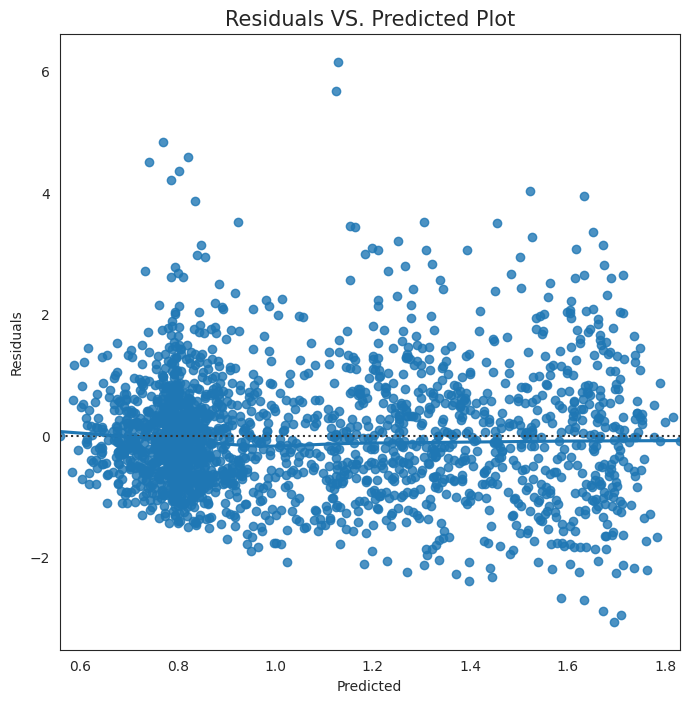

In [ ]:
X = geoIncluData[['S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone','DP05_Pct_RACE_One_race_Asian','B05006_Americas_Latin_America_Caribbean','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone']]
ypred = res.predict(X) # calculate y-predicted to plot predicted/residual plot

plt.rcParams['figure.figsize'] = [8,8]

sns.set_style('white')
sns.residplot(x=ypred,y=res.resid_pearson, lowess=True)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals VS. Predicted Plot",fontsize=15)
plt.show()


<ipython-input-48-ef4b86b63af0>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(res.resid_pearson)


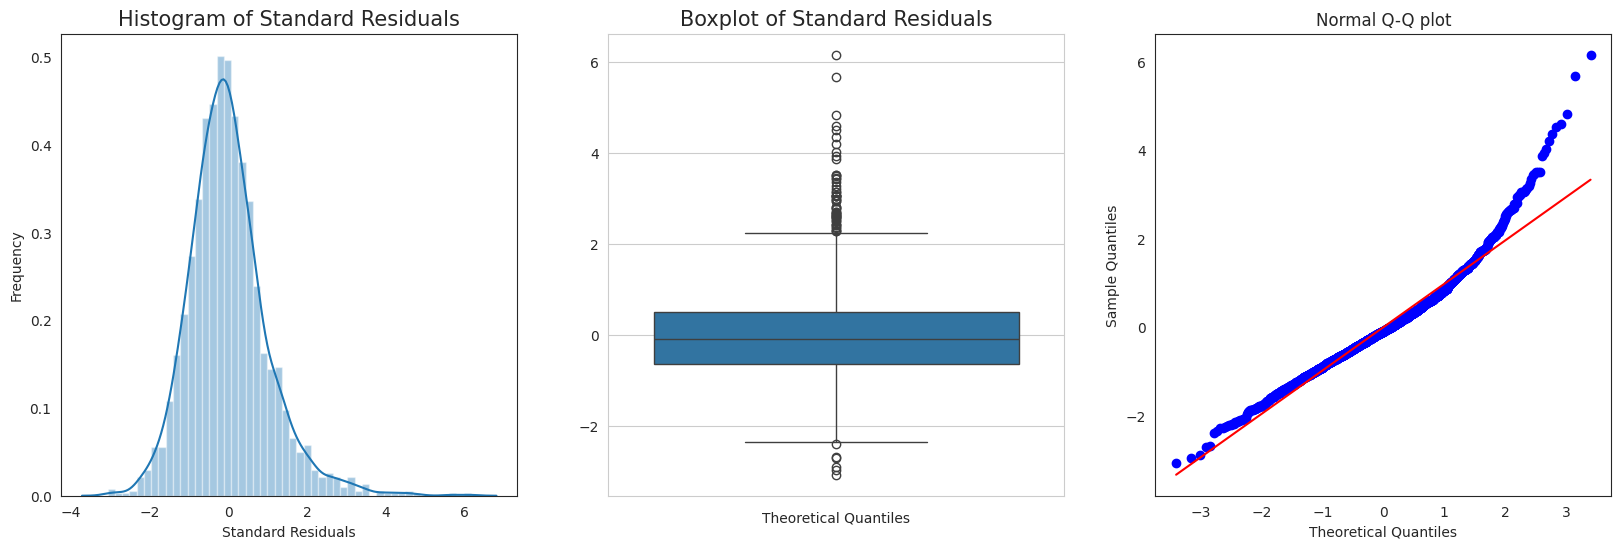

In [ ]:
# Check if residuals are normally distributed
plt.rcParams["figure.figsize"] = (20,6)

plt.subplot(131)
sns.distplot(res.resid_pearson)
plt.xlabel("Standard Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Standard Residuals",fontsize=15)

sns.set_style('whitegrid')
plt.subplot(132)
sns.boxplot(res.resid_pearson)
plt.xlabel("Theoretical Quantiles")
plt.title("Boxplot of Standard Residuals",fontsize=15)

sns.set_style('white')
plt.subplot(133)
stats.probplot(res.resid_pearson, dist="norm", plot=plt)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.title("Normal Q-Q plot")
plt.show()

In [ ]:
y = geoIncluData['Prostate_SIR']
X = geoIncluData[['S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone','DP05_Pct_RACE_One_race_Asian','B05006_Americas_Latin_America_Caribbean','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone']]

reg = LinearRegression().fit(X,y)
y_pred = reg.predict(X)
print('RFECV')
print('Model Score:', reg.score(X,y))
print('RMSE of the regression residuals:', np.sqrt(mean_squared_error(y, y_pred)))
print('MAE Model:', mean_absolute_error(y, y_pred))
print('')

# split data for calibration and validation | 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# learn relationship from training data
reg = LinearRegression().fit(X_train,y_train)

y_pred = reg.predict(X_train)
print('Training Score (r\u00b2):', 1 - (1-reg.score(X_train, y_train))*(len(X_train)-1)/(len(X_train)-X_train.shape[1]-1))
print('RMSE Train:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('MAE Train:', mean_absolute_error(y_train, y_pred))
print('')

y_pred = reg.predict(X_test)
print('Testing Score (r\u00b2):', 1 - (1-reg.score(X_test, y_test))*(len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))
print('RMSE Test:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAE Test:', mean_absolute_error(y_test, y_pred))

RFECV
Model Score: 0.4162669080673582
RMSE of the regression residuals: 0.3896936617463491
MAE Model: 0.2894493018454234

Training Score (r²): 0.41540213006286153
RMSE Train: 0.38957197574797214
MAE Train: 0.2866195864330794

Testing Score (r²): 0.3938014333434605
RMSE Test: 0.3904255066802737
MAE Test: 0.3028147096116161


## GWR

In [ ]:
#MODEL1 geoIncluData[['S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone']]
#MODEL2 geoIncluData[['S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone','B05006_Americas_Latin_America_Caribbean']]
#MODEL3 geoIncluData[['S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone','B05006_Americas_Latin_America_Caribbean','S0701_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born']]
#MODEL4 geoIncluData[['S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_White_alone','DP05_Pct_RACE_One_race_Asian','B05006_Americas_Latin_America_Caribbean','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone']]


In [ ]:
p_y = geoIncluData['Prostate_SIR'].values.reshape((-1,1)) # establish dependent variable
p_X = geoIncluData[['B05006_Americas_Latin_America_Caribbean','S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated','S2201_Pct_RACE_AND_HISPANIC_OR_LATINO_ORIGIN_OF_HOUSEHOLDER_Black_or_African_American_alone']].values # establish independent variable

u = geoIncluData['point'].x # x values from centroid
v = geoIncluData['point'].y # y values from centroid
p_coords = list(zip(u,v)) # coordinate pairs

p_X = (p_X - p_X.mean(axis=0)) / p_X.std(axis=0) # residuals / std dev = studentized residuals (easier to identify outliers)
p_y = p_y.reshape((-1,1))
p_y = (p_y - p_y.mean(axis=0)) / p_y.std(axis=0)

#Calibrate GWR model
gwr_bw = Sel_BW(p_coords, p_y, p_X).search() #Find optimal bandwidth using golden section, adaptive bisquare
# print('Number of Neighbors (Bandwidth) =', gwr_bw)
gwr_results = GWR(p_coords, p_y, p_X, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2067
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1226.879
Log-likelihood:                                                   -2393.846
AIC:                                                               4795.693
AICc:                                                              4797.722
BIC:                                                             -14521.761
R2:                                                                   0.406
Adj. R2:                                                              0.406

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

min 0.039635545510439796 | median 0.24785330242157816 | mean 0.2702100795037833 | max 0.6238267393999395



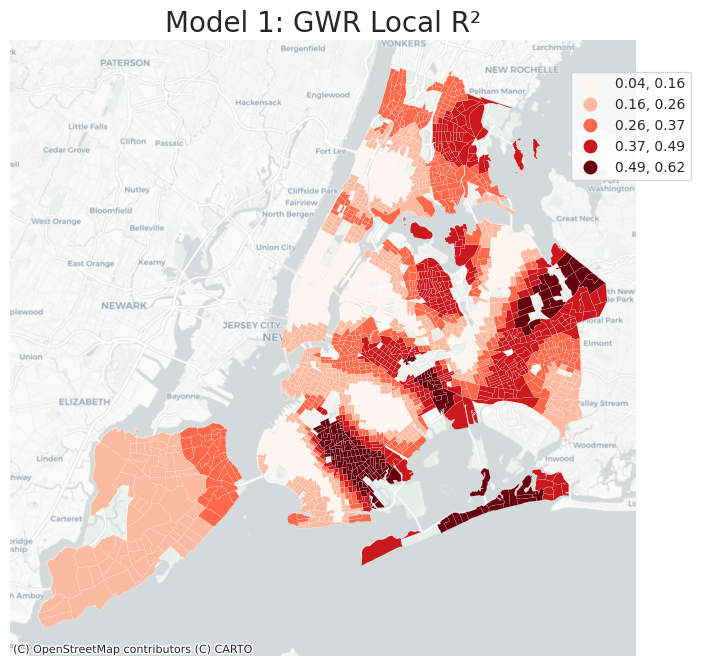

In [ ]:
# Local Model Fit

geoIncluData['gwr_R2'] = gwr_results.localR2

print('min',geoIncluData['gwr_R2'].min(), '| median',geoIncluData['gwr_R2'].median(), '| mean',geoIncluData['gwr_R2'].mean(), '| max',geoIncluData['gwr_R2'].max())
print('')

geoIncluData.plot('gwr_R2', cmap='Reds', linewidth = 0.1, scheme = 'naturalbreaks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)}, figsize=(30,8))
ax = plt.gca()
ax.set_axis_off()
contextily.add_basemap(ax, crs=geoIncluData.crs, source=contextily.providers.CartoDB.Positron)
plt.title('Model 1: GWR Local R\u00b2', fontsize=20)
plt.show()


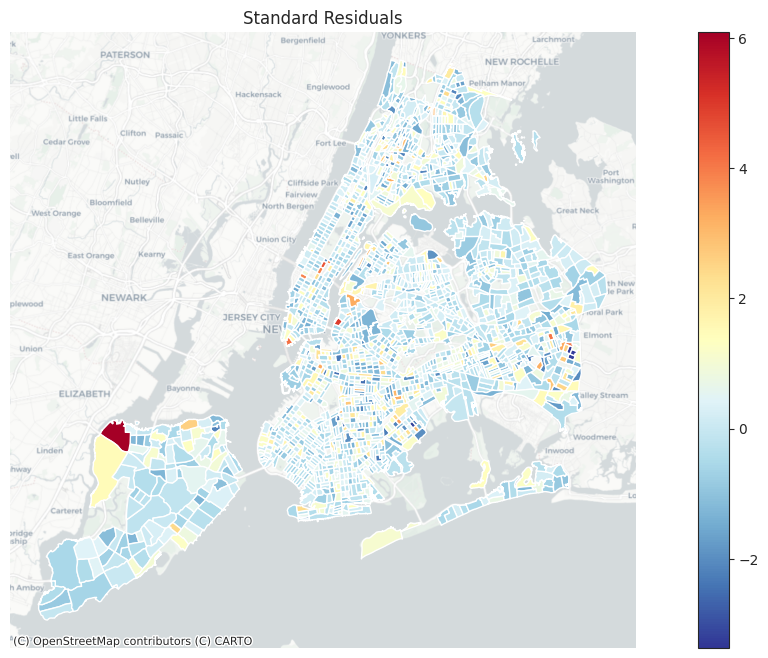

In [ ]:
# Map Standard Residuals

geoIncluData['stdRes'] = gwr_results.std_res
geoIncluData.plot('stdRes', cmap='RdYlBu_r', legend = True, figsize=(16,8))
ax = plt.gca()
ax.set_axis_off()
contextily.add_basemap(ax, crs=geoIncluData.crs, source=contextily.providers.CartoDB.Positron)
plt.title("Standard Residuals")
plt.show()

<ipython-input-54-413f2b7bee02>:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(STDresiduals)


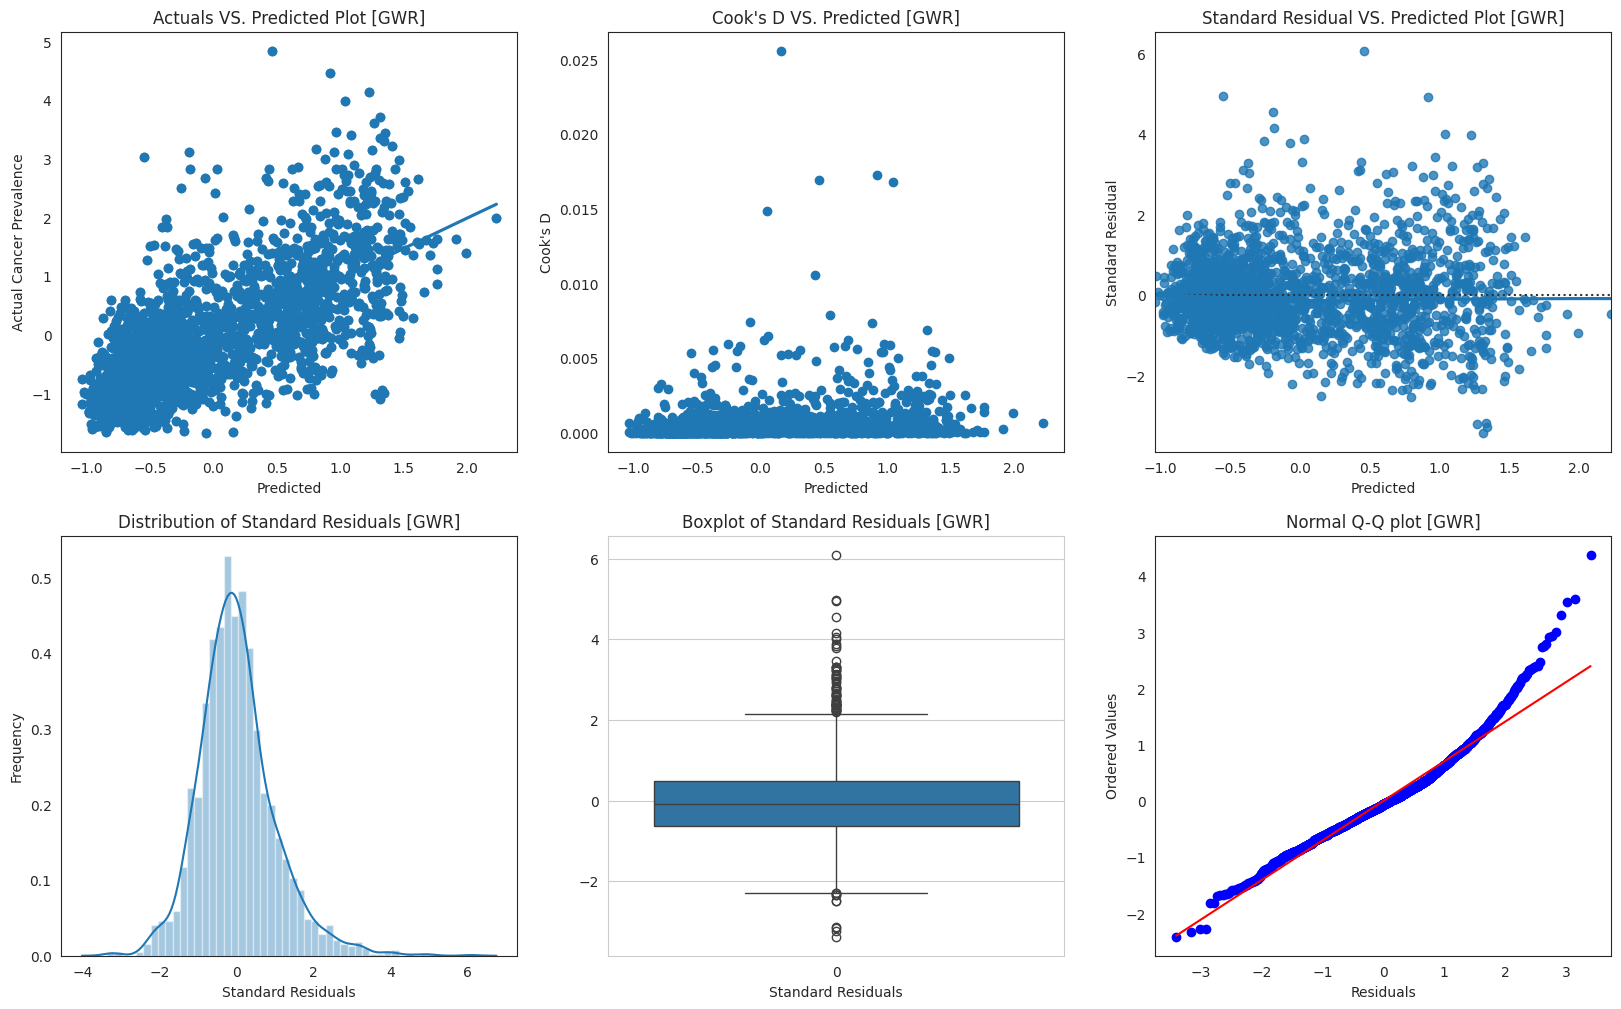

In [ ]:
y_pred = gwr_results.predy
STDresiduals = gwr_results.std_res
residuals = gwr_results.resid_response
actuals = gwr_results.y
cookD = gwr_results.cooksD

plt.rcParams["figure.figsize"] = (20,12)
sns.set_style('white')

plt.subplot(231)
plt.scatter(y_pred, actuals)
sns.regplot(x=y_pred,y=actuals, lowess=True)
plt.title("Actuals VS. Predicted Plot [GWR]")
plt.xlabel("Predicted")
plt.ylabel("Actual Cancer Prevalence")

plt.subplot(232)
plt.scatter(y_pred, cookD)
plt.title("Cook's D VS. Predicted [GWR]")
plt.xlabel("Predicted")
plt.ylabel("Cook's D")
# Critical Cook's D = 0.00534045393

# Residual VS. Predicted Plot
plt.subplot(233)
sns.residplot(y = STDresiduals, x = y_pred, lowess = True)
plt.title("Standard Residual VS. Predicted Plot [GWR]")
plt.xlabel("Predicted") #x label
plt.ylabel("Standard Residual") #y label

plt.subplot(234)
sns.set_style('darkgrid')
sns.distplot(STDresiduals)
plt.title("Distribution of Standard Residuals [GWR]")
plt.xlabel("Standard Residuals")
plt.ylabel("Frequency")

sns.set_style('whitegrid')
plt.subplot(235)
sns.boxplot(STDresiduals)
plt.xlabel("Standard Residuals")
plt.title("Boxplot of Standard Residuals [GWR]")

sns.set_style('white')
plt.subplot(236)
stats.probplot(residuals, dist="norm", plot=plt)
plt.xlabel("Residuals")
plt.title("Normal Q-Q plot [GWR]")
plt.show()


In [ ]:
## Global Moran's I on residuals

w = ps.weights.Queen.from_dataframe(geoIncluData) # calculate spatial weight based data and conceptualized spatial relationships is Queens case (aka contiguity edges corners)
w.transform = 'r' # row standardize
y = geoIncluData['stdRes'].values.reshape((-1,1))#.astype('int64')

mi = esda.moran.Moran(y, w, permutations= 9999) # p < 0.001 at 999 permutations
print('Observed Value:', mi.I, '| Expected Value:', mi.EI, '| Z-Score', mi.z_norm, '| Significance:', mi.p_sim)
print('')
print("The Global Moran's I statistics indicates that the data exhibits a random pattern of the residuals")

<ipython-input-55-f79d2708e5c0>:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = ps.weights.Queen.from_dataframe(geoIncluData) # calculate spatial weight based data and conceptualized spatial relationships is Queens case (aka contiguity edges corners)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 4 islands with ids: 949, 1305, 1560, 2059.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 949, ' is an island (no neighbors)')
('WARNING: ', 1305, ' is an island (no neighbors)')
('WARNING: ', 1560, ' is an island (no neighbors)')
('WARNING: ', 2059, ' is an island (no neighbors)')
Observed Value: 0.026759384052126425 | Expected Value: -0.000484027105517909 | Z-Score 2.0443569285198113 | Significance: 0.0236

The Global Moran's I statistics indicates that the data exhibits a random pattern of the residuals


# Neighborhood Analysis

In [ ]:
combinedCO = geoIncluData.assign(COanalysis=labels).reset_index(drop=True)
# combinedCO = pd.concat([combinedCO, geoOutlierData], ignore_index=True, axis=0)
combinedCO[['Prostate_SIR', 'COanalysis']].groupby('COanalysis').count()#.to_csv('CO analysis count.csv')

Prostate_SIR
COanalysis                       
0 Not Significant            1366
1 Hot Spot (HH)               273
2 Cold Outlier (LH)            54
3 Cold Spot (LL)              264
4 Hot Outlier (HL)            110

In [ ]:
combinedCO[['Prostate_SIR','TotalPopulation','COanalysis', # Comment out 'COanalysis' for entire study area total
'DP05_SEX_AND_AGE_Total_population_Male',
'DP05_Pct_SEX_AND_AGE_Total_population_Male',
'DP05_SEX_AND_AGE_18_years_and_over_Male',
'DP05_Pct_SEX_AND_AGE_18_years_and_over_Male',
'DP05_SEX_AND_AGE_65_years_and_over_Male',
'DP05_Pct_SEX_AND_AGE_65_years_and_over_Male',
'DP05_SEX_AND_AGE_Median_age_years',

'DP05_Pct_HISPANIC_OR_LATINO_AND_RACE_Total_population_Not_Hispanic_or_Latino_Black_or_African_American_alone',
'DP05_Pct_HISPANIC_OR_LATINO_AND_RACE_Total_population_Not_Hispanic_or_Latino_White_alone',
'DP05_Pct_HISPANIC_OR_LATINO_AND_RACE_Total_population_Not_Hispanic_or_Latino_Asian_alone',
'DP05_Pct_HISPANIC_OR_LATINO_AND_RACE_Total_population_Not_Hispanic_or_Latino_Some_other_race_alone',
'DP05_Pct_HISPANIC_OR_LATINO_AND_RACE_Total_population_Hispanic_or_Latino_of_any_race',

'B06008_Estimate_Total',
'S0701_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born',
'B06008_Foreign_born_Never_married',
'B06008_Foreign_born_Now_married_except_separated',
'B06008_Foreign_born_Divorced',
'B06008_Foreign_born_Separated',
'B06008_Foreign_born_Widowed',
'S0601_MARITAL_STATUS_Population_15_years_and_over_Never_married',
 'S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated',
 'S0601_MARITAL_STATUS_Population_15_years_and_over_Divorced_or_separated',
 'S0601_MARITAL_STATUS_Population_15_years_and_over_Widowed',
'B05002_Total_Foreign_born','B06003_Foreign_born','B06008_Foreign_born',
  'S0701_NATIVITY_AND_CITIZENSHIP_STATUS_Native',
 'S0701_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born',
 'S1603_NATIVITY_AND_CITIZENSHIP_STATUS_Native',
 'S1603_NATIVITY_AND_CITIZENSHIP_STATUS_Foreign_born',

 'B06008_Born_in_state_of_residence',
 'B06008_Born_in_other_state_in_the_United_States',
'OBESITY_CrudePrev',
'BPHIGH_CrudePrev',
'CASTHMA_CrudePrev',
'CHECKUP_CrudePrev',
'COREM_CrudePrev',
'DIABETES_CrudePrev',
'SLEEP_CrudePrev',
'landfillTractCount',

'S2201_Pct_households_receiving_food_stamps_SNAP_Estimate_Households',
'S1701_Below_poverty_level_Estimate_UNRELATED_INDIVIDUALS_FOR_WHOM_POVERTY_STATUS_IS_DETERMINED_Male',
'B17001_Income_in_the_past_12_months_below_poverty_level_Male',
'B17001_Income_in_the_past_12_months_at_or_above_poverty_level_Male',
'S2201_HOUSEHOLD_INCOME_IN_THE_PAST_12_MONTHS_IN_2015_INFLATION_ADJUSTED_DOLLARS_Median_income_dollars',
'S2201_Pct_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_At_or_above_poverty_level',
'S2201_Pct_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_Below_poverty_level',
'S0601_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_Population_for_whom_poverty_status_is_determined_100_to_149_Pct_of_the_poverty_level',
'S0601_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_Population_for_whom_poverty_status_is_determined_Below_100_Pct_of_the_poverty_level',
'S0701_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_Population_1_year_and_over_for_whom_poverty_status_is_determined_Below_100_Pct_of_the_poverty_level',
'S0701_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_Population_1_year_and_over_for_whom_poverty_status_is_determined_100_to_149_Pct_of_the_poverty_level',
'S0701_POVERTY_STATUS_IN_THE_PAST_12_MONTHS_Population_1_year_and_over_for_whom_poverty_status_is_determined_At_or_above_150_Pct_of_the_poverty_level',
'S2701_RATIO_OF_INCOME_TO_POVERTY_LEVEL_IN_THE_PAST_12_MONTHS_Civilian_noninstitutionalized_population_for_whom_poverty_status_is_determined_Below_138_Pct_of_the_poverty_threshold',
'S2701_RATIO_OF_INCOME_TO_POVERTY_LEVEL_IN_THE_PAST_12_MONTHS_Civilian_noninstitutionalized_population_for_whom_poverty_status_is_determined_138_to_199_Pct_of_the_poverty_threshold',
'S2701_RATIO_OF_INCOME_TO_POVERTY_LEVEL_IN_THE_PAST_12_MONTHS_Civilian_noninstitutionalized_population_for_whom_poverty_status_is_determined_200_to_399_Pct_of_the_poverty_threshold',
'S2701_RATIO_OF_INCOME_TO_POVERTY_LEVEL_IN_THE_PAST_12_MONTHS_Civilian_noninstitutionalized_population_for_whom_poverty_status_is_determined_At_or_above_400_Pct_of_the_poverty_threshold',

'S0601_EDUCATIONAL_ATTAINMENT_Population_25_years_and_over_Bachelors_degree',
'S0601_EDUCATIONAL_ATTAINMENT_Population_25_years_and_over_Less_than_high_school_graduate',
'S0601_EDUCATIONAL_ATTAINMENT_Population_25_years_and_over_Some_college_or_associates_degree',
'S1501_Pct_Males_Estimate_Population_25_years_and_over_9th_to_12th_grade_no_diploma',
'S1501_Pct_Males_Estimate_Population_25_years_and_over_Associates_degree',
'S1501_Pct_Males_Estimate_Population_25_years_and_over_Bachelors_degree',
'S1501_Pct_Males_Estimate_Population_25_years_and_over_Some_college_no_degree',
'S1501_Pct_Males_Estimate_White_alone_not_Hispanic_or_Latino_High_school_graduate_or_higher',
'S1501_Pct_Males_Estimate_White_alone_not_Hispanic_or_Latino_Bachelors_degree_or_higher',
'S1501_Pct_Males_Estimate_Black_alone_High_school_graduate_or_higher',
'S1501_Pct_Males_Estimate_Black_alone_Bachelors_degree_or_higher',
'S1501_Pct_Males_Estimate_Asian_alone_High_school_graduate_or_higher',
'S1501_Pct_Males_Estimate_Asian_alone_Bachelors_degree_or_higher',
'S1501_Pct_Males_Estimate_Some_other_race_alone_High_school_graduate_or_higher',
'S1501_Pct_Males_Estimate_Some_other_race_alone_Bachelors_degree_or_higher',
'S1501_Pct_Males_Estimate_Two_or_more_races_High_school_graduate_or_higher',
'S1501_Pct_Males_Estimate_Two_or_more_races_Bachelors_degree_or_higher',
'S1501_Pct_Males_Estimate_Hispanic_or_Latino_Origin_High_school_graduate_or_higher',
'S1501_Pct_Males_Estimate_Hispanic_or_Latino_Origin_Bachelors_degree_or_higher',
'S2701_Insured_Estimate_SEX_Male',
'S2701_Pct_Insured_Estimate_SEX_Male',
'S2701_Uninsured_Estimate_SEX_Male',
'S2701_Pct_Uninsured_Estimate_SEX_Male',

'S0601_MARITAL_STATUS_Population_15_years_and_over_Divorced_or_separated',
'S0601_MARITAL_STATUS_Population_15_years_and_over_Never_married',
'S0601_MARITAL_STATUS_Population_15_years_and_over_Now_married_except_separated',
'S2201_Pct_HOUSEHOLD_TYPE_Married_couple_family',
'S2201_Pct_HOUSEHOLD_TYPE_No_children_under_18_years_Married_couple_family',
'S2201_Pct_HOUSEHOLD_TYPE_No_children_under_18_years_Other_family',
'S2201_Pct_HOUSEHOLD_TYPE_Other_family']].groupby('COanalysis').mean()#.to_csv('CO mean.csv') # REMOVE .groupby('COanalysis') for totals

Prostate_SIR  TotalPopulation  \
COanalysis                                           
0 Not Significant        1.000149      4000.467789   
1 Hot Spot (HH)          1.740731      3575.549451   
2 Cold Outlier (LH)      0.769744      3214.648148   
3 Cold Spot (LL)         0.644901      4110.787879   
4 Hot Outlier (HL)       1.237485      3775.045455   

                     DP05_SEX_AND_AGE_Total_population_Male  \
COanalysis                                                    
0 Not Significant                               1967.656662   
1 Hot Spot (HH)                                 1698.402930   
2 Cold Outlier (LH)                             1537.851852   
3 Cold Spot (LL)                                2055.409091   
4 Hot Outlier (HL)                              1849.336364   

                     DP05_Pct_SEX_AND_AGE_Total_population_Male  \
COanalysis                                                        
0 Not Significant                                     47.989239   
1 Hot Spot (HH)                                       45.356410   
2 Cold Outlier (LH)                                   46.255556   
3 Cold Spot (LL)                                      49.119697   
4 Hot Outlier (HL)                                    48.413636   

                     DP05_SEX_AND_AGE_18_years_and_over_Male  \
COanalysis                                                     
0 Not Significant                                1522.685212   
1 Hot Spot (HH)                                  1235.578755   
2 Cold Outlier (LH)                              1136.777778   
3 Cold Spot (LL)                                 1629.916667   
4 Hot Outlier (HL)                               1481.327273   

                     DP05_Pct_SEX_AND_AGE_18_years_and_over_Male  \
COanalysis                                                         
0 Not Significant                                      47.124890   
1 Hot Spot (HH)                                        43.672161   
2 Cold Outlier (LH)                                    45.175926   
3 Cold Spot (LL)                                       48.308712   
4 Hot Outlier (HL)                                     48.089091   

                     DP05_SEX_AND_AGE_65_years_and_over_Male  \
COanalysis                                                     
0 Not Significant                                 213.273060   
1 Hot Spot (HH)                                   157.304029   
2 Cold Outlier (LH)                               133.925926   
3 Cold Spot (LL)                                  249.890152   
4 Hot Outlier (HL)                                199.927273   

                     DP05_Pct_SEX_AND_AGE_65_years_and_over_Male  \
COanalysis                                                         
0 Not Significant                                      40.999927   
1 Hot Spot (HH)                                        38.294139   
2 Cold Outlier (LH)                                    35.022222   
3 Cold Spot (LL)                                       42.373485   
4 Hot Outlier (HL)                                     40.852727   

                     S0701_Median_age_years  \
COanalysis                                    
0 Not Significant                 36.942826   
1 Hot Spot (HH)                   36.205861   
2 Cold Outlier (LH)               35.562963   
3 Cold Spot (LL)                  38.376136   
4 Hot Outlier (HL)                38.128182   

                     DP05_SEX_AND_AGE_Median_age_years  ...  \
COanalysis                                              ...   
0 Not Significant                            36.546266  ...   
1 Hot Spot (HH)                              35.791941  ...   
2 Cold Outlier (LH)                          35.166667  ...   
3 Cold Spot (LL)                             37.975379  ...   
4 Hot Outlier (HL)                           37.740909  ...   

                     S2701_Pct_Insured_Estimate_SEX_Male  \
COanalysis                                    